In [1]:
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
from skimage import transform
%matplotlib inline

In [2]:
small_pics = !(ls small/)
big_pics = !(ls big/)

In [3]:
def cross_correlation(im1, im2):
    h, w = im1.shape
    im1 = im1.astype(int)
    im2 = im2.astype(int)
    res = np.sum(im1 * im2) / (np.sum(im1 ** 2) ** 0.5 * np.sum(im2 ** 2) ** 0.5)
    return res

In [4]:
def MSE(im1, im2):
    h, w = im1.shape
    im1 = im1.astype(int)
    im2 = im2.astype(int)
    return np.sum((im1 - im2) ** 2 / h / w)

In [5]:
def split_image(img):
    channels = []
    h = img.shape[0] // 3
    img = img[:img.shape[0] - img.shape[0] % 3, :]
    channels.append(img[h * 2:,:])
    channels.append(img[h:h * 2,:])
    channels.append(img[:h, :])
    
    for i, img in enumerate(channels):
        h,l = np.int0(np.array(img.shape) * 0.05)
        channels[i] = img[h : img.shape[0] - h, l : img.shape[1] - l]
    return channels

In [6]:
def displace_images(im1, im2, dh, dw):
    I1 = im1
    I2 = im2
    if dh > 0:
        I1 = I1[dh:, :]
    elif dh < 0:
        I2 = I2[-dh:, :]
    if dw > 0:
        I1 = I1[:, dw:]
    elif dw < 0:
        I2 = I2[:, -dw:]
    return I1, I2

def resize_images(images):
    h = min([im.shape[0] for im in images])
    w = min([im.shape[1] for im in images])
    return [im[:h, :w] for im in images]

In [7]:
def find_best_offset(im1, im2, metrics, h_min, h_max, w_min, w_max):
    if metrics == 'mse':
        best_score = 100000000000
    else:
        best_score = 0
        # let minimize -cross_correlation
    res = [0,0]
    
    for dh in range(h_min,h_max + 1):
        for dw in range(w_min,w_max + 1):
            I1, I2 = resize_images(displace_images(im1, im2, dh, dw))
            if metrics == 'mse':
                cur_score = MSE(I1,I2)
            else:
                cur_score = -cross_correlation(I1,I2)
            if cur_score < best_score:
                res = [dh, dw]
                best_score = cur_score
    return res    

In [8]:
def align(img):
    metrics = 'cross'
    # оказалось, что обе метрики - что MSE, что cross_correlation, дают одинаковые результаты
    # при этом вторая считается быстрее
    im1, im2, im3 = split_image(img)
    im_pyramid = [(im1,im2,im3)]
    while im1.shape[0] > 500:
        im1 = im1[::2, ::2]
        im2 = im2[::2, ::2]
        im3 = im3[::2, ::2]
        im_pyramid.append((im1,im2,im3))
        
    h1, h2, w1, w2 = 0, 0, 0, 0
    for im1, im2, im3 in reversed(im_pyramid):
        if h1 ** 2 + h2 ** 2 + w1 ** 2 + w2 ** 2 == 0:
            h1, w1 = find_best_offset(im1, im2, metrics, -15, 15, -15, 15)
            im1, im2 = resize_images(displace_images(im1, im2, h1, w1))
            h2, w2 = find_best_offset(im1, im3, metrics, -15, 15, -15, 15)
        else:
            h1, w1 = find_best_offset(im1, im2, metrics, 2 * h1 - 1, 2 * h1 + 1, 2 * w1 - 1, 2 * w1 + 1)
            im1, im2 = resize_images(displace_images(im1, im2, h1, w1))
            h2, w2 = find_best_offset(im1, im3, metrics, 2 * h2 - 1, 2 * h2 + 1, 2 * w2 - 1, 2 * w2 + 1)
            
    im1, _ = displace_images(im1, im3, h2, w2)
    im2, im3 = displace_images(im2, im3, h2, w2)
    im1, im2, im3 = resize_images([im1, im2, im3])
    return np.stack(np.array([im1, im2, im3]), axis=2)

# Small

CPU times: user 2.24 s, sys: 73.3 ms, total: 2.32 s
Wall time: 2.23 s
CPU times: user 2.72 s, sys: 217 ms, total: 2.93 s
Wall time: 2.7 s
CPU times: user 2.72 s, sys: 230 ms, total: 2.95 s
Wall time: 2.74 s
CPU times: user 2.73 s, sys: 193 ms, total: 2.92 s
Wall time: 2.71 s
CPU times: user 2.72 s, sys: 210 ms, total: 2.93 s
Wall time: 2.69 s
CPU times: user 2.97 s, sys: 210 ms, total: 3.18 s
Wall time: 2.94 s
CPU times: user 2.99 s, sys: 263 ms, total: 3.25 s
Wall time: 2.96 s


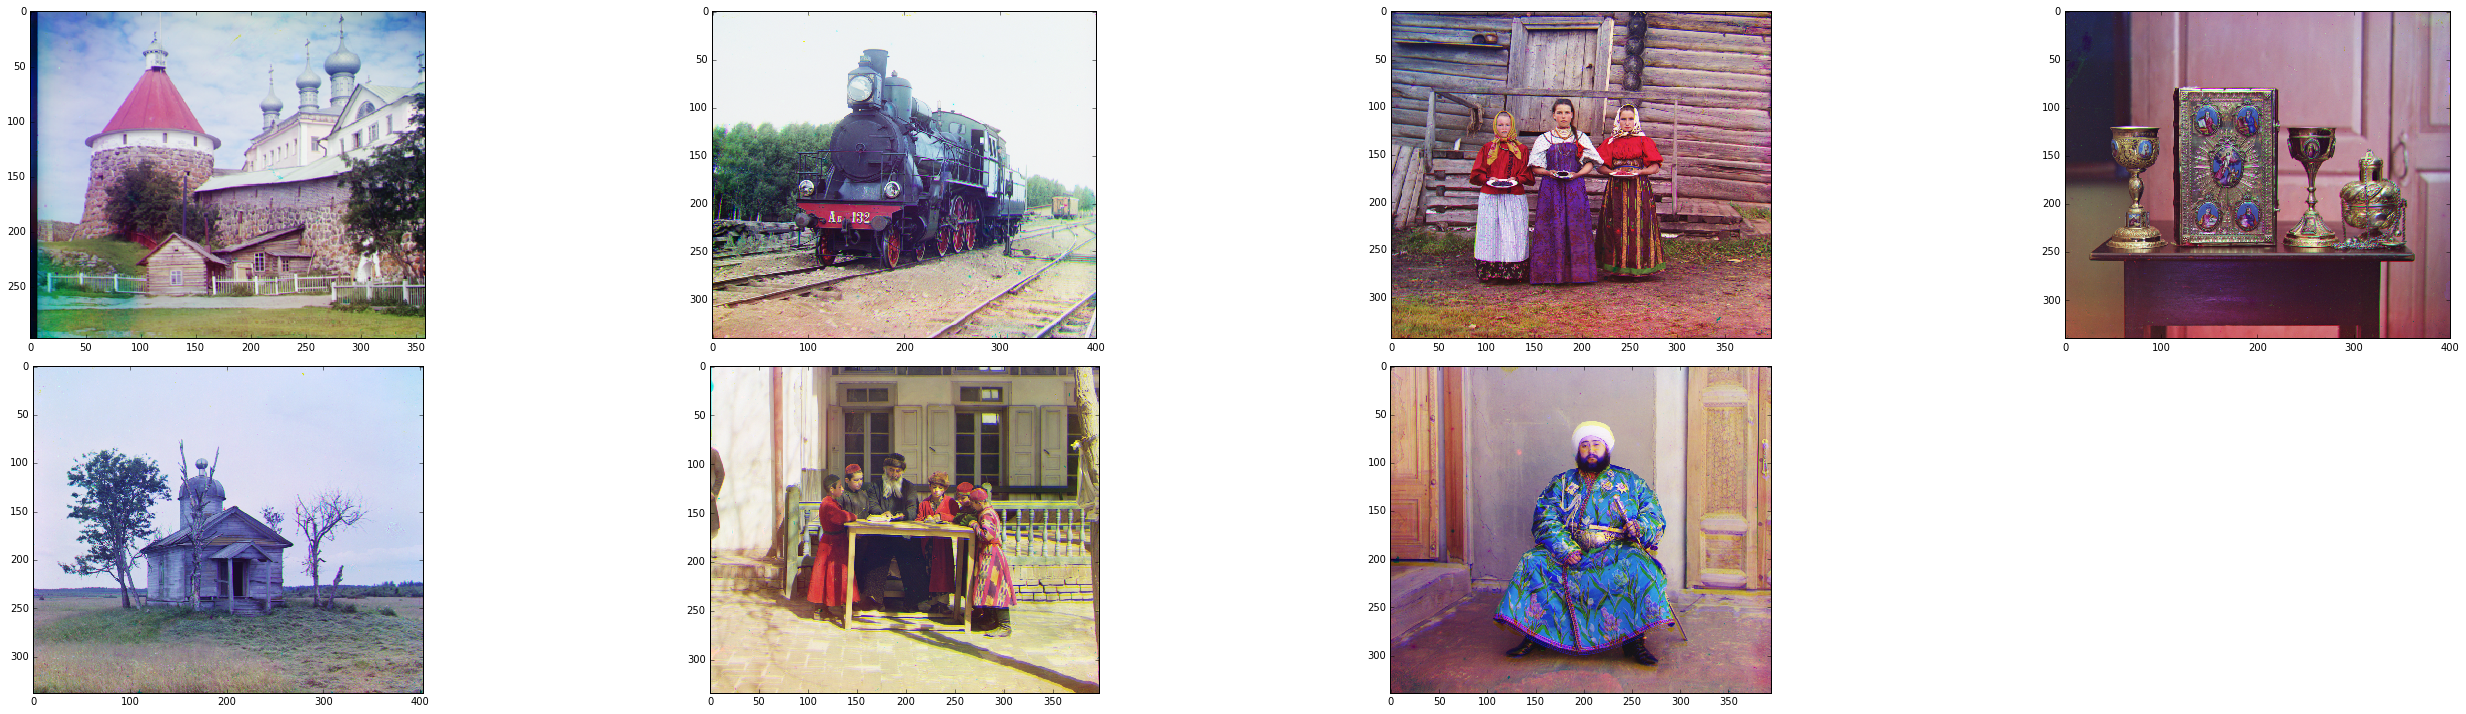

In [10]:
plt.figure(figsize=(40,10))
for pl_num, f_name in enumerate(small_pics):
    img = io.imread('small/' + f_name)
    plt.subplot(2,4,pl_num + 1)
    %time io.imshow(align(img))

# Big

CPU times: user 7.8 s, sys: 1.33 s, total: 9.13 s
Wall time: 9.48 s
CPU times: user 8.05 s, sys: 1.19 s, total: 9.24 s
Wall time: 9.1 s
CPU times: user 7.48 s, sys: 1.18 s, total: 8.66 s
Wall time: 8.51 s
CPU times: user 7.05 s, sys: 1.12 s, total: 8.17 s
Wall time: 8.01 s
CPU times: user 7.94 s, sys: 967 ms, total: 8.9 s
Wall time: 8.7 s
CPU times: user 7.4 s, sys: 1.21 s, total: 8.61 s
Wall time: 8.39 s
CPU times: user 7.76 s, sys: 1.23 s, total: 9 s
Wall time: 8.75 s


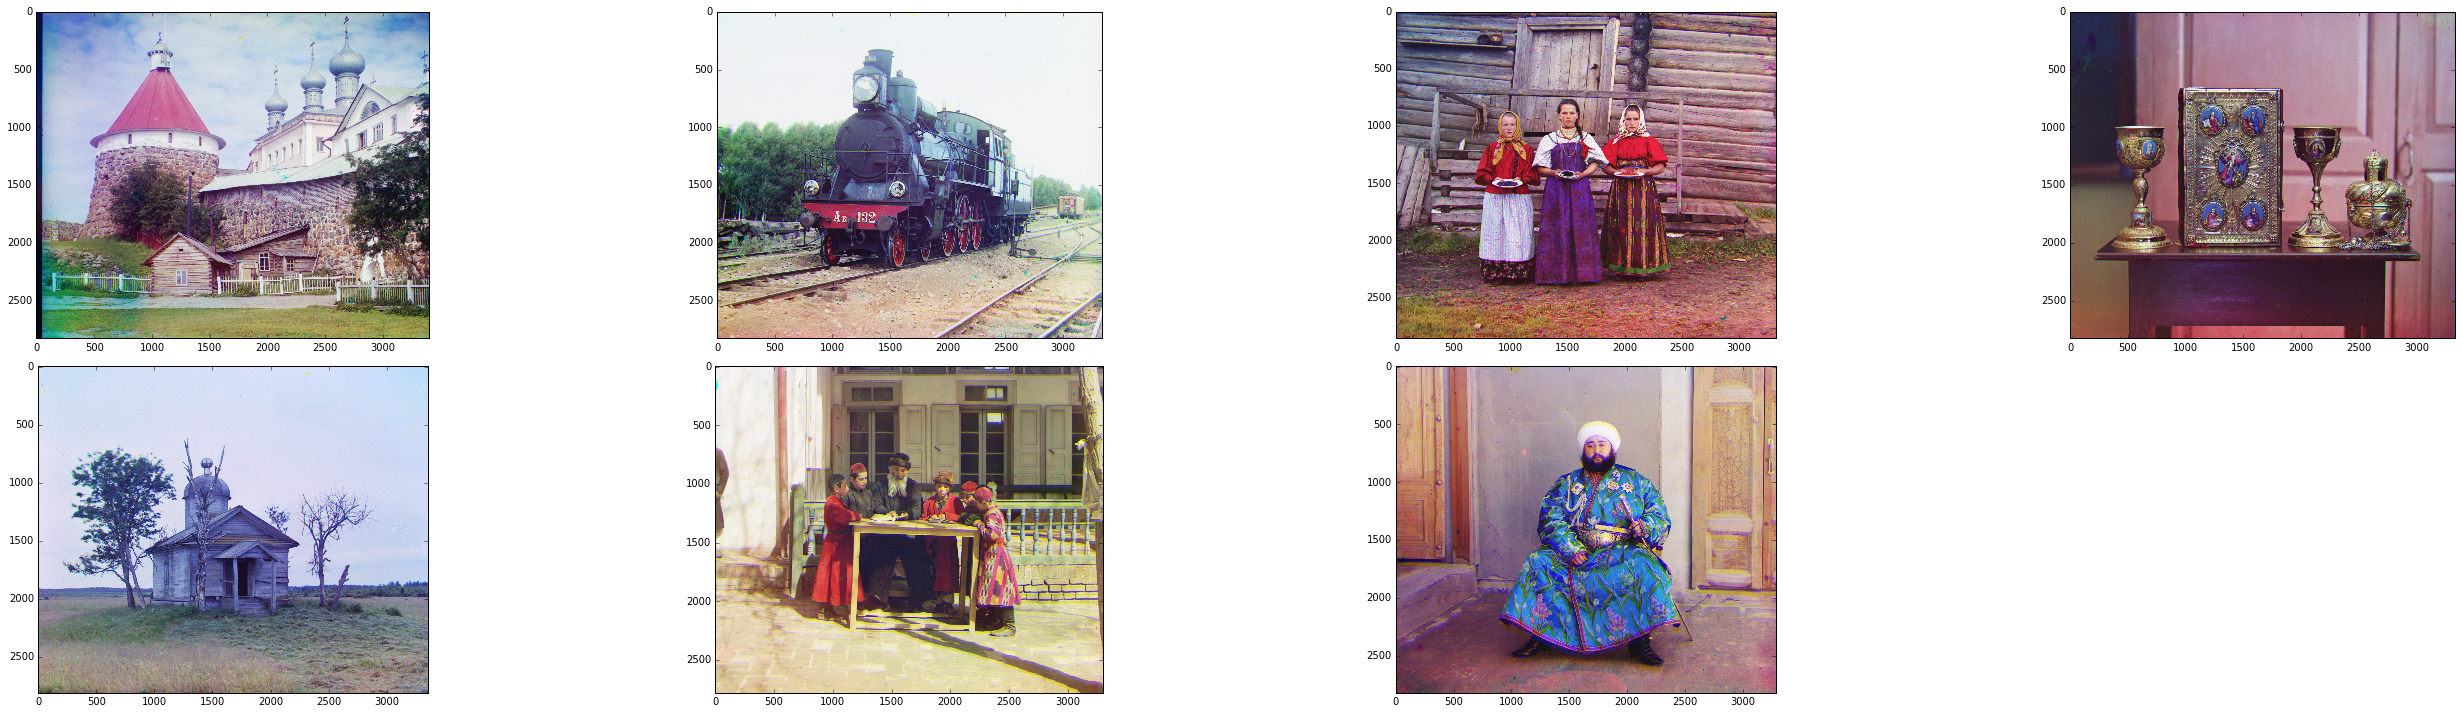

In [11]:
plt.figure(figsize=(40,10))
for pl_num, f_name in enumerate(big_pics):
    img = io.imread('big/' + f_name)
    plt.subplot(2,4,pl_num + 1)
    %time io.imshow(align(img))